# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_ForecastingTrader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.6.0'

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

In [4]:
pd.__version__

'0.24.2'

In [5]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [6]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [7]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [9]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')

# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [10]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values


In [11]:
len(df_prices_train)+len(df_prices_test)

195414

# Load Pairs

In [12]:
# intraday
n_years_train = round(len(df_prices_train)/(240*78))
train_val_split = '2017-01-01'

Function to evaluate forecasting results:

In [18]:
def evaluate_forecasting(n_pairs, true_values, prediction_values):
    mse, mae, rmse, accuracy, bias = list(), list(), list(), list(), list()
    std_dev = list()
    for i in range(n_pairs):
        mse.append(mean_squared_error(true_values[i], prediction_values[i]))
        rmse.append(np.sqrt(mean_squared_error(true_values[i], prediction_values[i])))
        mae.append(mean_absolute_error(true_values[i], prediction_values[i]))
        accuracy.append(forecasting_trader.calculate_direction_accuracy(true_values[i], prediction_values[i]))
        bias.append((true_values[i] - prediction_values[i]).mean())
        std_dev.append(prediction_values[i].std())
    print('{:.2f}E-4'.format(np.mean(mse)*10000))#Average MSE: 
    print('{:.2f}E-3'.format(np.mean(rmse)*1000))#Average RMSE: 
    print('{:.2f}E-3'.format(np.mean(mae)*1000))#Average RMSE: 
    print('{:.2f}%'.format(np.mean(accuracy)))#Average Directional Accuracy: 
    #print('Bias: {:.2f}E-4'.format(np.mean(bias)*10000))
    #print('Average Standard Deviation from prediction signal ', np.mean(std_dev))
    
    return mse, mae, rmse, accuracy

# ARMA/ARIMA Model

In [13]:
from statsmodels.tsa.arima_model import ARIMA
    
def predict(coef, history, flag):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
        
    return yhat

def static_ARIMA(spread_train, spread_test, p, d, q):

    # normalize data
    scaler = StandardScaler()
    spread_train_norm = scaler.fit_transform(spread_train.values.reshape(spread_train.shape[0],1)) 
    spread_train_norm = pd.Series(data=spread_train_norm.flatten(), index=spread_train.index)

    # spread test
    spread_test_norm = scaler.transform(spread_test.values.reshape(spread_test.shape[0],1)) 
    spread_test_norm = pd.Series(data=spread_test_norm.flatten(), index=spread_test.index)

    train, train_except_val, train_val, test = spread_train_norm.values, spread_train_norm[:'2017-01-01'].values,\
                                               spread_train_norm['2017-01-01':].values, spread_test_norm.values
    history, history_val = np.asarray(train), np.asarray(train_except_val)
    history_train = np.asarray(spread_train_norm.values[:p+1])
    predictions, predictions_val, predictions_train = list(), list(), list()
    residuals, residuals_val, residuals_train = list(), list(), list()
    
    #print('Start model fitting...')
    start = time.time()
    model = ARIMA(history, order=(p,d,q))
    #model = ARIMA(history_val, order=(p,d,q)) # to be consistent with the other
                                          # when comparing validation error
    model_fit = model.fit(transparams=False, tol=0.0001, trend='nc', disp=1)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams 
    resid = model_fit.resid 
    end = time.time()
    print('Finished model fitting... Time elapsed: ',(end - start))
    print(model_fit.summary())
    
    # validation data
    residuals_val.extend(resid)
    for t in range(len(train_val)): 
        yhat = predict(ar_coef, history_val, 'ar') + predict(ma_coef, residuals_val, 'ma')
        predictions_val.append(yhat)
        obs = train_val[t]
        history_val = np.append(history_val, obs)
        residuals_val.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
        
    # train data
    #residuals_train.extend(resid)
    #for t in range(len(train_except_val)): 
    #    yhat = predict(ar_coef, history_train, 'ar') + predict(ma_coef, residuals_train, 'ma')
    #    predictions_train.append(yhat)
    #    obs = train[t]
    #    history_train = np.append(history_train, obs)
    #    residuals_train.append(obs - yhat)
    #    sys.stdout.write('\r'+str(t))
    predictions_train = predictions_val # just to fill up
    
    # test data
    residuals.extend(resid)
    for t in range(len(test)): 
        yhat = predict(ar_coef, history, 'ar') + predict(ma_coef, residuals, 'ma')
        predictions.append(yhat)
        obs = test[t]
        history = np.append(history, obs)
        residuals.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
        
    # destandardize
    predictions, predictions_val, predictions_train = np.array(predictions), np.array(predictions_val),\
                                                      np.array(predictions_train)
    predictions =  scaler.inverse_transform(predictions.reshape(predictions.shape[0],1)).flatten()
    predictions_val =  scaler.inverse_transform(predictions_val.reshape(predictions_val.shape[0],1)).flatten()
    predictions_train = scaler.inverse_transform(predictions_train.reshape(predictions_train.shape[0],1)).flatten()
    
    # plot
    test = scaler.inverse_transform(test.reshape(test.shape[0],1)).flatten()
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    predictions = pd.Series(data=predictions, index=spread_test.index, name='ARMA_predictions')
    predictions_val = pd.Series(data=predictions_val, index=spread_train['2017-01-01':].index,
                                name='ARMA_predictions_val')
    predictions_train = pd.Series(data=predictions_val, index=spread_train['2017-01-01':].index,
                                name='ARMA_predictions_train')
                        #pd.Series(data=predictions_train, index=spread_train[:'2017-01-01'].index,
                        #          name='ARMA_predictions_train')
    
    return predictions, predictions_val, predictions_train

Contrarily from the Neural Network models, predicting the time step t+n implies training until t+n-1, due to the residuals that must be inferred.

In [14]:
current_path=('forecasting_models/rnn_5_pairs_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

5

In [1396]:
p,q = 2,4

Pair: 1/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  253.3194739818573
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(2, 4)   Log Likelihood              269201.534
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Aug 2019   AIC                        -538389.068
Time:                        15:29:51   BIC                        -538318.519
Sample:                             0   HQIC                       -538368.188
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.6402      0.001   2894.044      0.000       1.639       1.641
ar.L2.y       -0.6403      0.001  -1130.133      0.000      -0.641      

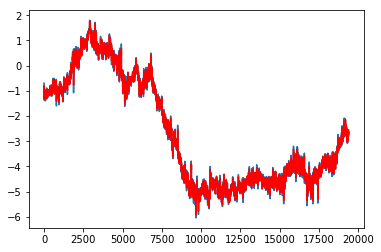

Pair: 2/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  265.32669401168823
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(2, 4)   Log Likelihood              380211.967
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Aug 2019   AIC                        -760409.935
Time:                        15:34:53   BIC                        -760339.386
Sample:                             0   HQIC                       -760389.055
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.4835      0.001   1697.070      0.000       1.482       1.485
ar.L2.y       -0.4836      0.001   -553.346      0.000      -0.485     

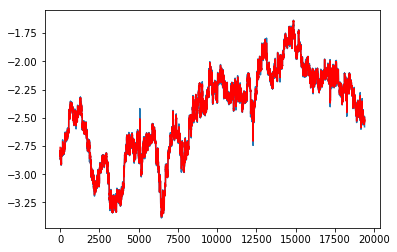

Pair: 3/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  264.15957903862
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(2, 4)   Log Likelihood              347441.317
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Aug 2019   AIC                        -694868.635
Time:                        15:39:48   BIC                        -694798.086
Sample:                             0   HQIC                       -694847.755
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.5231      0.001   2496.157      0.000       1.522       1.524
ar.L2.y       -0.5232      0.001   -857.605      0.000      -0.524      -0

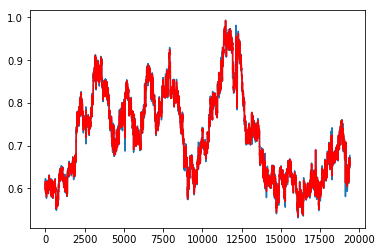

Pair: 4/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  269.6634159088135
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(2, 4)   Log Likelihood              329014.943
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Aug 2019   AIC                        -658015.885
Time:                        15:44:54   BIC                        -657945.337
Sample:                             0   HQIC                       -657995.005
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.7500   9.86e-05   1.77e+04      0.000       1.750       1.750
ar.L2.y       -0.7501   9.86e-05  -7610.325      0.000      -0.750      

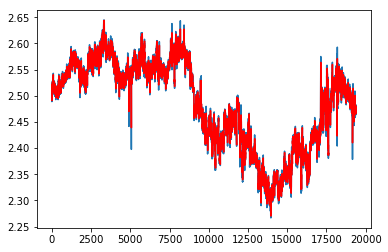

Pair: 5/5

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  275.25277066230774
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(2, 4)   Log Likelihood              174367.972
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 17 Aug 2019   AIC                        -348721.943
Time:                        15:50:08   BIC                        -348651.395
Sample:                             0   HQIC                       -348701.063
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.3380      0.011    117.541      0.000       1.316       1.360
ar.L2.y       -0.3383      0.011    -29.738      0.000      -0.361     

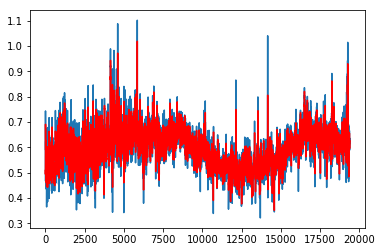

In [1397]:
arima_predictions_train, arima_predictions_val, arima_predictions_test = [], [], []
arima_train, arima_val, arima_test = [], [], []
for i, pair in enumerate(pairs):
    sys.stdout.write("\r"+'Pair: {}/{}'.format(i + 1, len(pairs)))
    sys.stdout.flush()
    spread_train = pair[2]['spread']
    spread_test = (pair[2]['Y_test'] - pair[2]['coint_coef']*pair[2]['X_test'])

    pair_predictions_test, pair_predictions_val, pair_predictions_train = static_ARIMA(spread_train,
                                                                                       spread_test,
                                                                                       p, 0, q)
    # add predictions
    arima_predictions_train.append(pair_predictions_train)
    arima_predictions_val.append(pair_predictions_val)
    arima_predictions_test.append(pair_predictions_test)
    # add spreads
    arima_train.append(spread_train[:'2017-01-01'])
    arima_val.append(spread_train['2017-01-01':])
    arima_test.append(spread_test)    

In [ ]:
arma_pickle = {'arima_train':arima_train,
               'arima_val':arima_val,
               'arima_test':arima_test,
               'arima_predictions_train':arima_predictions_train,
               'arima_predictions_val':arima_predictions_val,
               'arima_predictions_test':arima_predictions_test}
name = 'arima_p{}_q{}.pkl'.format(p,q)
with open('forecasting_models/arima/'+name, 'wb') as handle:
    pickle.dump(arma_pickle, handle)

In [19]:
with open('forecasting_models/arima/arima_p8_q3.pkl', 'rb') as handle:
    arma_pickle = pickle.load(handle)
arima_val, arima_test = arma_pickle['arima_val'], arma_pickle['arima_test']
arima_predictions_val, arima_predictions_test = arma_pickle['arima_predictions_val'],\
                                                arma_pickle['arima_predictions_test']

Train:

In [20]:
#_ = evaluate_forecasting(len(pairs), arima_train, arima_predictions_train)

Validation: 

For validation must load the file arima_p8_q3_val.pkl, which corresponds to the predictions when the model is trained without the validation set.

In [21]:
_ = evaluate_forecasting(len(pairs), arma_pickle['arima_val'], arma_pickle['arima_predictions_val'])

14.93E-4
29.88E-3
17.60E-3
39.02%


Test:

In [22]:
_ = evaluate_forecasting(len(pairs), arima_test, arima_predictions_test)

22.64E-4
33.39E-3
19.64E-3
40.13%


## Trading with ARMA

In [23]:
# model to test
low_quantile = 0.20
high_quantile = 0.80

**Validation**



Annual ROI:  2.2095583462846458
60.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.5816448283954206
Autocorrelation:  0.2394399393756413
Daily Sharpe Ratio 0.03676744176316551
Total number of trades:  345
Positive trades:  135
Negative trades:  210
Total Drawdown Days: 78 days
Max DD period: 107.0 days
Maximum drawdown of portfolio: -2.40%
2.21% - 0.58  -2.40%-107.0d - 78d


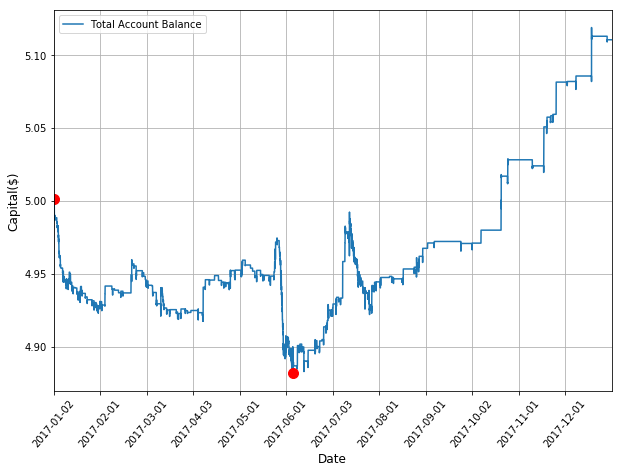

In [29]:
cumret_val, sharperatio_val = list(), list()
balance_summaries_arma, summaries_arma = list(), list()
for pair_i in range(len(pairs)):
    predictions = arima_predictions_val[pair_i]
    #predictions = arima_val[pair_i].shift(1).fillna(0)
    spread_train = pairs[pair_i][2]['spread'][:train_val_split]
    spread_val = arima_val[pair_i]
    
    ret, cumret, summary, balance_summary = forecasting_trader.forecast_spread_trading(
                                                        X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                        Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                        spread_test=spread_val,#[-len(predictions):],
                                                        spread_train=spread_train,
                                                        beta=pairs[pair_i][2]['coint_coef'],
                                                        predictions=predictions,
                                                        lag=1,
                                                        low_quantile=low_quantile,
                                                        high_quantile=high_quantile,
                                                        multistep=0)
    
    #print('Accumulated return: {:.2f}%'.format(cumret[-1] * 100))

    if np.std(ret) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, ret)
    else:
        sharpe_ratio = 0
    #print('Sharpe Ratio:', sharpe_ratio)

    cumret_val.append(cumret[-1] * 100)
    sharperatio_val.append(sharpe_ratio)
    summaries_arma.append(summary)
    balance_summaries_arma.append(balance_summary)
performance_arma = [(summaries_arma[i], balance_summaries_arma[i]) for i in range(len(pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_arma,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [1829]:
print('Corrrected Sharpe Ratio: ', 0.03676744176316551*12.92)

Corrrected Sharpe Ratio:  0.47503534758009835


In [ ]:
initial = 0
final=50
sampling = 1
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(summaries_arma[-1]['prediction(t)'].values[initial:final:sampling], color='blue', label='Forecast')
plt.plot(summaries_arma[-1]['spread(t)'].values[initial:final:sampling], color='red', label='Spread')
plt.plot(summaries_arma[-1]['position_during_day'].values[initial:final:sampling], color='orange',
         label='Position')
dates = summaries_arma[0]['prediction(t)'][initial:final:sampling].index[::1]
xi = np.arange(0, len(summaries_arma[-1]['prediction(t)'][initial:final:sampling]), 1)
plt.xticks(xi, dates, rotation=90)
plt.legend()
plt.show()

**Test with profitable pairs in validation**

In [30]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]



Annual ROI:  5.56849160600783
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  1.2397443046907535
Autocorrelation:  0.05262178949758675
Daily Sharpe Ratio 0.07668221198730535
Total number of trades:  34
Positive trades:  22
Negative trades:  12
Total Drawdown Days: 11 days
Max DD period: 22.0 days
Maximum drawdown of portfolio: -0.73%


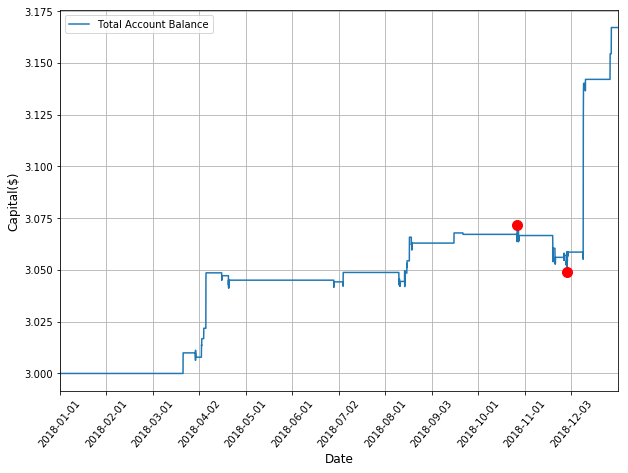

In [33]:
cumret_test, sharperatio_test = list(), list()
balance_summaries_arma, summaries_arma = list(), list()
for pair_i in profitable_pairs_indices.flatten():
    predictions = arima_predictions_test[pair_i]
    spread_train = pairs[pair_i][2]['spread']
    spread_test = arima_test[pair_i]
    
    ret, cumret, summary, balance_summary = forecasting_trader.forecast_spread_trading(
                                                        X=pairs[pair_i][2]['X_test'],
                                                        Y=pairs[pair_i][2]['Y_test'],
                                                        spread_test=spread_test[-len(predictions):],
                                                        spread_train=pairs[pair_i][2]['spread'],
                                                        beta=pairs[pair_i][2]['coint_coef'],
                                                        predictions=predictions,
                                                        lag=1,
                                                        low_quantile=low_quantile,
                                                        high_quantile=high_quantile,
                                                        multistep=0)
    
    #print('Accumulated return: {:.2f}%'.format(cumret[-1] * 100))

    if np.std(ret) != 0:
        sharpe_ratio = trader.calculate_sharpe_ratio(1, 252, ret)
    else:
        sharpe_ratio = 0
    #print('Sharpe Ratio:', sharpe_ratio)

    cumret_test.append(cumret[-1] * 100)
    sharperatio_test.append(sharpe_ratio)
    summaries_arma.append(summary)
    balance_summaries_arma.append(balance_summary)

if len(profitable_pairs)>1:
    performance_arma = [(summaries_arma[i], balance_summaries_arma[i]) for i in range(len(profitable_pairs))]
    print('\n')
    results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_arma,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)

In [32]:
print('Corrrected Sharpe Ratio: ', 0.07668221198730535*(252**0.5))

Corrrected Sharpe Ratio:  1.217292377404476


# Trying some ANN based models

In [34]:
def plot_loss(history, title, epoch_stop, metric='mse'):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    plt.figure(figsize=(7,5))
    plt.grid()
    if metric == 'mse':
        plt.plot(history['loss'], label = "Training MSE")
        plt.plot(history['val_loss'], label = "Validation MSE")
        plt.plot([epoch_stop], [history['val_loss'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MSE:{:.3f}'.format(history['val_loss'][epoch_stop]),
            xy=(epoch_stop, history['val_loss'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Squared Error', size=12)
    elif metric == 'mae':
        plt.plot(history['mean_absolute_error'], label = "Training MAE")
        plt.plot(history['val_mean_absolute_error'], label = "Validation MAE")
        plt.plot([epoch_stop], [history['val_mean_absolute_error'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MAE:{:.3f}'.format(history['val_mean_absolute_error'][epoch_stop]),
            xy=(epoch_stop, history['val_mean_absolute_error'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Absolute Error', size=12)
    plt.xlabel('Epochs', size=12)
    plt.legend()
    plt.savefig('{}_history.png'.format(metric), bbox='tight')
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

**Load models ran in the server**

In [35]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

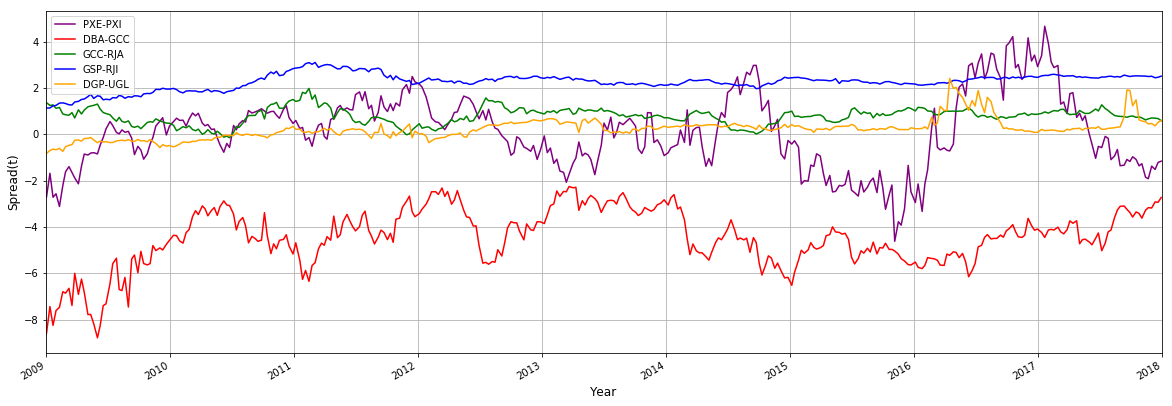

In [36]:
#markers= ["o","s","+","x","<"]
colors = ['purple', 'r', 'g', 'blue', 'orange']
for i in range(len(pairs)):
    pairs[i][2]['spread'][::500].plot(figsize=(20,7), grid=True, label='{}-{}'.format(pairs[i][0],pairs[i][1]),
                                       c=colors[i])#,marker=markers[i])
plt.ylabel('Spread(t)',size=12)
plt.xlabel('Year',size=12)
plt.xlim(('2009', '2018'))
plt.legend()

## RNN

## Grid Search

In [37]:
current_path=('forecasting_models/rnn_5_pairs_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

# WARNING
#current_path=('forecasting_models/rnn_5_pairs_optical/no_training_rnn/')

5

In [38]:
rnn_models = read_models(path=current_path)

In [39]:
# model to test
n_in = 24
hidden_nodes = [50]
low_quantile = 0.10
high_quantile = 0.90

**Validation**



Annual ROI:  1.7418677608551203
60.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.6516664407069852
Autocorrelation:  0.05346502645347421
Daily Sharpe Ratio 0.04090246744236697
Total number of trades:  130
Positive trades:  60
Negative trades:  70
Total Drawdown Days: 51 days
Max DD period: 13.0 days
Maximum drawdown of portfolio: -0.82%


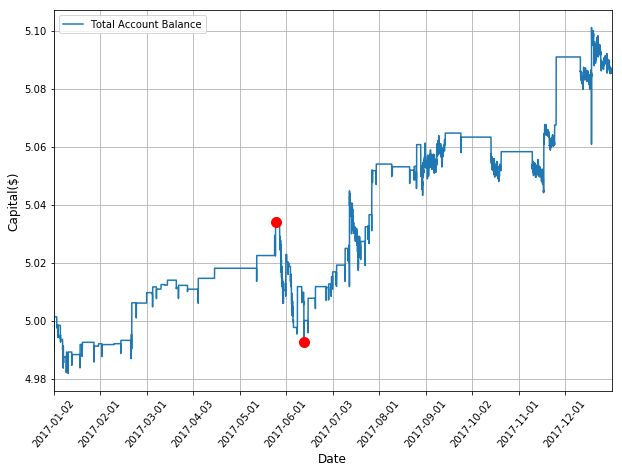

In [42]:
model_rnn, cumret_val, sharperatio_val,summaries_rnn, balance_summaries_rnn = \
            forecasting_trader.run_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile, lag=1)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [43]:
print('Corrected Sharpe Ratio:', 0.04090246744236697*15.81)

Corrected Sharpe Ratio: 0.6466680102638218


Training:

In [44]:
init = model_rnn[0]['predictions_train'].index[0]
true_train = [pairs[i][2]['spread'][init:train_val_split] for i in range(len(pairs))]
predictions_train = [model_rnn[i]['predictions_train'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_train, predictions_train)

22.39E-4
40.43E-3
25.42E-3
38.42%


Validation:

In [45]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

16.98E-4
32.75E-3
20.35E-3
38.97%


**Test unrestricted**



Annual ROI:  0.3658355102338806
60.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  -0.728312846115596
Autocorrelation:  0.04303657672875861
Daily Sharpe Ratio -0.04466539796744567
Total number of trades:  110
Positive trades:  54
Negative trades:  56
Total Drawdown Days: 127 days
Max DD period: 198.0 days
Maximum drawdown of portfolio: -2.20%


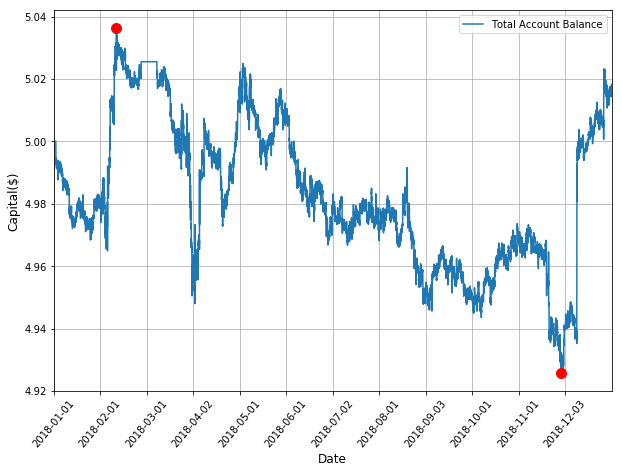

In [47]:
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=range(len(pairs)))
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

Test:

In [48]:
true_test = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

33.48E-4
42.98E-3
30.84E-3
40.61%


**Test with active pairs on validation set**



Annual ROI:  2.9333521319509615
66.66666666666667 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.4969018168662862
Autocorrelation:  -0.0086396880003628
Daily Sharpe Ratio 0.031555590854708014
Total number of trades:  8
Positive trades:  6
Negative trades:  2
Total Drawdown Days: 2 days
Max DD period: 161.0 days
Maximum drawdown of portfolio: -0.47%


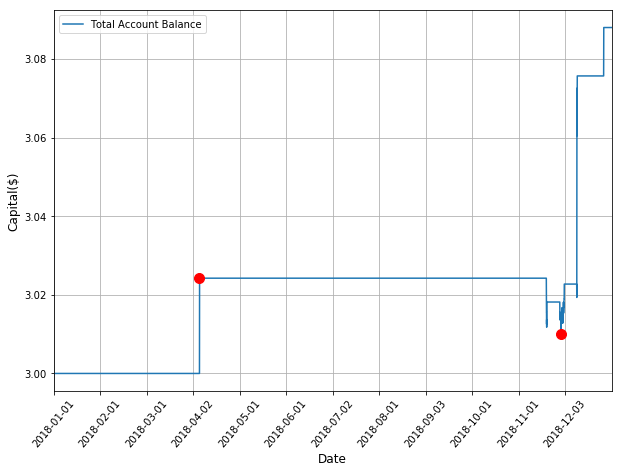

In [49]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(profitable_pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)

In [50]:
print('Corrected Sharpe Ratio', 0.031555590854708014*15.81)

Corrected Sharpe Ratio 0.4988938914129337


## Encoder-Decoder LSTM Multi-step Forecasting

### Grid Search

In [51]:
current_path=('forecasting_models/encoder_decoder_5_optical/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

5

In [52]:
models = read_models(current_path)

In [53]:
# model to test
n_in = 24
hidden_nodes = [15, 15]
low_quantile = 0.10
high_quantile = 0.90



Annual ROI:  1.3974568991074188
60.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.296327635872095
Autocorrelation:  0.03761026813715462
Daily Sharpe Ratio 0.018943177209514172
Total number of trades:  187
Positive trades:  80
Negative trades:  107
Total Drawdown Days: 70 days
Max DD period: 40.0 days
Maximum drawdown of portfolio: -1.62%


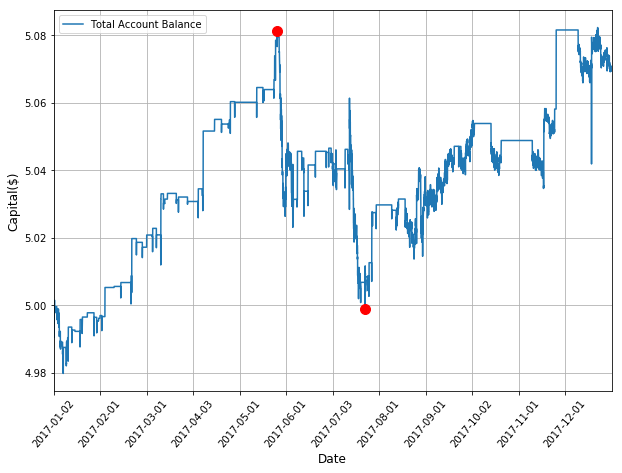

In [54]:
model_encdec, cumret_val, sharperatio_val, summaries_encdec, balance_summaries_encdec = \
            forecasting_trader.run_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile,
                                                  lag=1, multistep=1)
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_encdec,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [64]:
print('Corrected Sharpe Ratio: ', 0.018943177209514172*(252**0.5))

Corrected Sharpe Ratio:  0.300713615626806


Validation:

In [56]:
true_val = [summaries_encdec[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

17.10E-4
33.20E-3
21.29E-3
38.97%


In [57]:
true_val = [summaries_encdec[i]['spread(t)'].shift(1).fillna(method='bfill') for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t+1)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

20.51E-4
36.02E-3
24.51E-3
38.95%


## Result for thesis

In [1770]:
#i = 4
#plot_loss(model[i]['history'], 'Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]),
#         epoch_stop = model[i]['epoch_stop'], metric='mse')

In [1771]:
#i = 4
#print('Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]))
#plot_loss(model[i]['history'], 'Loss history from {}-{} spread training'.format(pairs[i][0], pairs[i][1]),
#         epoch_stop = model[i]['epoch_stop'], metric='mae')

**Test Unrestricted**



Annual ROI:  2.2282728844077893
60.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.11712568961614665
Autocorrelation:  -0.0032875164614243604
Daily Sharpe Ratio 0.008228684190166298
Total number of trades:  127
Positive trades:  68
Negative trades:  59
Total Drawdown Days: 124 days
Max DD period: 84.0 days
Maximum drawdown of portfolio: -1.64%


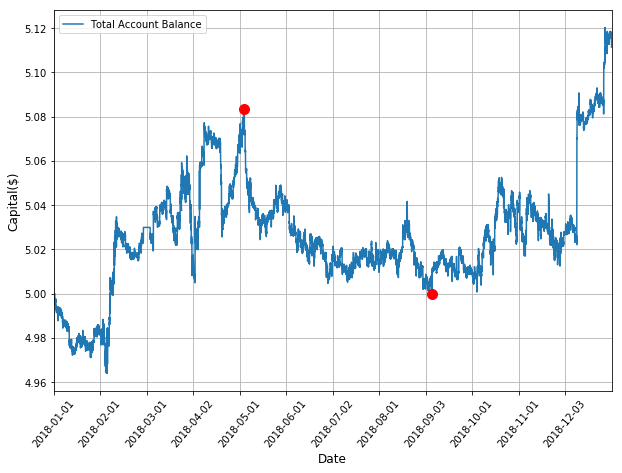

In [59]:
model_encdec, cumret_test, sharperatio_test ,summaries_encdec, balance_summaries_encdec = \
            forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs,
                                                  path=current_path,
                                                  low_quantile=low_quantile, high_quantile=high_quantile,
                                                  lag=1, multistep=1, profitable_pairs_indices=range(len(pairs)))
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_encdec,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [60]:
true_test = [summaries_encdec[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

43.14E-4
52.05E-3
39.37E-3
40.78%


In [61]:
true_test = [summaries_encdec[i]['spread(t)'].shift(1).fillna(method='bfill') for i in range(len(pairs))]
predictions = [summaries_encdec[i]['prediction(t+1)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

90.25E-4
75.02E-3
59.09E-3
40.65%


**Active pairs during validation**



Annual ROI:  4.1676054958179165
66.66666666666667 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.9864231146173382
Autocorrelation:  0.014212267722891568
Daily Sharpe Ratio 0.06148106753986127
Total number of trades:  17
Positive trades:  14
Negative trades:  3
Total Drawdown Days: 21 days
Max DD period: 26.0 days
Maximum drawdown of portfolio: -1.19%


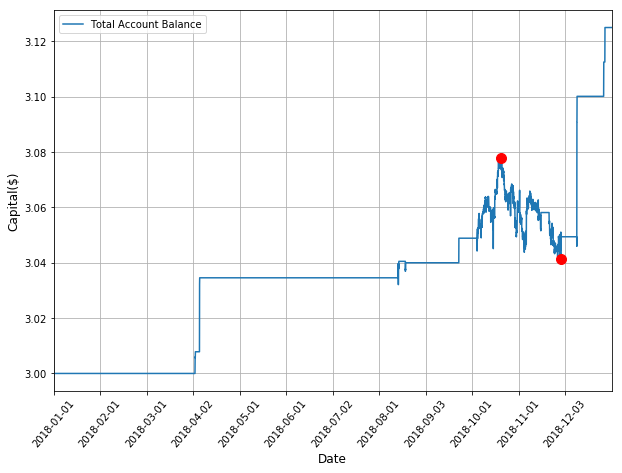

In [62]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model_encdec, cumret_test, sharperatio_test, summaries_encdec, balance_summaries_encdec = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               multistep=1,
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_encdec = [(summaries_encdec[i], balance_summaries_encdec[i]) for i in range(len(profitable_pairs))]
print('\n')
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_encdec,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)

In [63]:
print('Corrected Sharpe Ratio', 0.06148106753986127*15.81)

Corrected Sharpe Ratio 0.9720156778052067


# Results for Thesis

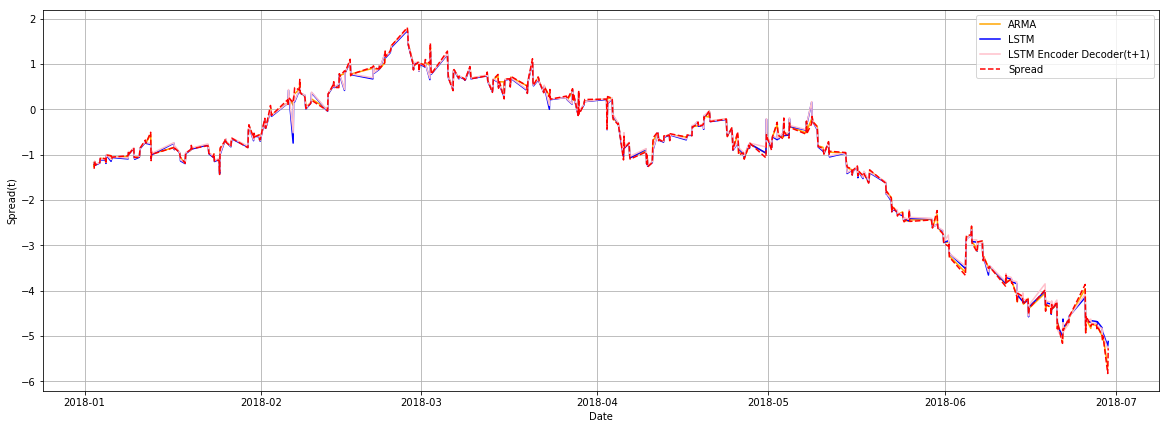

In [1819]:
sampling = 25
xmax = round(len(summaries_rnn[0]['prediction(t)'])/2)#100*78
plt.figure(figsize=(20,7))
plt.grid()
plt.plot(arima_predictions_test[0][:xmax:sampling], color='orange', label='ARMA')
plt.plot(summaries_rnn[0]['prediction(t)'][:xmax:sampling], color='blue', label='LSTM')
plt.plot(summaries_encdec[0]['prediction(t)'][:xmax:sampling], color='pink', label='LSTM Encoder Decoder(t+1)')
plt.plot(summaries_rnn[0]['spread(t)'][:xmax:sampling], color='red', linestyle='--', label='Spread')
plt.legend()
plt.xlabel('Date', size=10)
plt.ylabel('Spread(t)', size=10)
#plt.plot(summaries_encdec[0]['prediction(t)'].values[:xmax:sampling])